# 3.5. Решение линейного стока. Суперпозиция для произвольной истории дебитов

Материалы курсов "Исследования скважин и пластов" и "Гидродинамические исследования скважин" в РГУ нефти и газа имени И.М.Губкина.

Версия 0.1 от 17.10.2023


---

1. [Решение линейного стока](#351)
2. [Решение для произвольной истории дебитов (ступенчатое изменение дебита)](#352)
3. [Случай для произвольной истории дебитов (линейное изменение дебита)](#353)
4. [Задания для самостоятельной работы](#354)

# 1. Решение линейного стока <a class="anchor" id="351"></a>

In [1]:
# импортируем библиотеки для расчетов

# numpy используем для работы с массивами и подготовки данных для построения графиков. 
# Также в некоторых функциях используем возможности векторных расчетов numpy
import numpy as np

# matplotlib используем для построения графиков
import matplotlib.pyplot as plt

# импортируем ранее определенные расчетные функции
import sys
sys.path.append('..') # модуль с функциями располагается на уровень выше скрипта
from welltest import functions as wf

# 2. Решение для произвольной истории дебитов (ступенчатое изменение дебита) <a class="anchor" id="352"></a>

Для расчета изменения давления при переменном дебите введем произвольное референсное значение дебита $ q_{ref} $ (например первое не нулевое значение дебита при запуске скважины). Используем это значение для определения безразмерного давления.
$$ p_D = \frac{kh}{ 18.41 q_{ref} B \mu} \left( p_i - p \right) \tag{5} $$

и безразмерного дебита 

$$q_D = \frac{q}{q_{ref}} \tag{6}$$

Тогда, используя принцип суперпозиции, можем выписать выражение для изменения давления на скважине и вокруг нее для произвольного момента времени

$$P_{mr.D}(t_D, r_D) = \sum_i \left[ q_{D(i)}-q_{D(i-1)} \right] \cdot p_D\left(t_D-t_{D(i)}, r_D\right)\cdot \mathcal{H}(t_D-t_{D(i)}) \tag{7} $$

где

* $i$ - индекс значения дебита в таблице изменения дебитов
* $q_{D(i)}$ - безразмерный дебит с номером $i$, который стартует в момент времени $t_i$. Для первого момента времени $i$ дебит следующий перед ним считается равным нулю
* $t_{D(i)}$ - безразмерный момент времени - включения дебита с номером $i$
* $t_{D}$ - безразмерный момент времени для которого проводится расчет
* $\mathcal{H}$ - ступенчатая [функция Хевисайда](https://ru.wikipedia.org/wiki/%D0%A4%D1%83%D0%BD%D0%BA%D1%86%D0%B8%D1%8F_%D0%A5%D0%B5%D0%B2%D0%B8%D1%81%D0%B0%D0%B9%D0%B4%D0%B0#:~:text=%D0%A4%D1%83%D0%BD%D0%BA%D1%86%D0%B8%D1%8F%20%D0%A5%D0%B5%D0%B2%D0%B8%D1%81%D0%B0%D0%B9%D0%B4%D0%B0%20%D1%88%D0%B8%D1%80%D0%BE%D0%BA%D0%BE%20%D0%B8%D1%81%D0%BF%D0%BE%D0%BB%D1%8C%D0%B7%D1%83%D0%B5%D1%82%D1%81%D1%8F%20%D0%B2,%D0%B4%D0%BB%D1%8F%20%D0%B7%D0%B0%D0%BF%D0%B8%D1%81%D0%B8%20%D1%8D%D0%BC%D0%BF%D0%B8%D1%80%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%BE%D0%B9%20%D1%84%D1%83%D0%BD%D0%BA%D1%86%D0%B8%D0%B8%20%D1%80%D0%B0%D1%81%D0%BF%D1%80%D0%B5%D0%B4%D0%B5%D0%BB%D0%B5%D0%BD%D0%B8%D1%8F.)
* $p_D\left(t\right)$ - зависимость безразмерного давление от времени - решение задачи запуска скважины с постоянным единичным дебитом
* $P_{mr.D} $ - безразмерное давление $P_{mr.D}(t_D, r_D)$ учитывающее историю изменения дебитов скважины

In [2]:
# создадим историю изменения дебитов 

t_history = np.array([ 0., 2., 24. ], dtype=np.float64) 
q_history = np.array([10., 5., 0.], dtype=np.float64)

# массивы должны быть одной и той же длины

In [3]:
def pd_superposition(td, td_hist, qd_hist, rd):
    """
    расчет безразмерного давления для последовательности безразмерных дебитов
    td -  время расчета после запуска, безразмерное
    td_hist - массив времен изменения режимов работы скважин, безразмерное
    qd_hist - массив дебитов установленных после изменения режима работы, безразмерное
    """
    # принудительно добавим нули во входные массивы, чтобы учесть запуск скважины
    qdh = np.hstack([0, qd_hist])
    tdh = np.hstack([0, td_hist])
    # построим дебиты виртуальных скважин - разности реальных дебитов при переключении
    delta_qd = np.hstack([0, np.diff(qdh)])
    # референсный безразмерный дебит это 1
    
    # векторная магия - время может быть вектором и переключения дебитов тоже вектор
    # надо организовать сумму по временам, каждая из котороых сумма по переключениям
    # делаем при помощи расчета meshgrid и поиска накопленных сумм
    qd_v, td_v =np.meshgrid(delta_qd, td)
    # используем куммулятивную сумму numpy для того что суммировать результаты
    dpd = np.cumsum(qd_v * wf.pd_line_source_ei((td_v - tdh), rd) * np.heaviside((td_v - tdh), 1),1 )
    # последний столбец - полная сумма, которая нужна в качестве результата
    return dpd[:,-1]


def q_superposition(t, t_hist, q_hist):
    """
    расчет давления для запуска и последующей остановки скважины
    t_hr - время после запуска в часах
    t_hist_hr - массив времен изменения режимов работы скважин
    q_hist_sm3day - массив дебитов установленных после изменения режима работы
    """
    def interpolate_constant(x, xp, yp):
        indices = np.searchsorted(xp, x, side='right')
        y = np.concatenate(([0], yp))
        return y[indices]

    q=[]
    for ti in t:
        q.append(interpolate_constant(ti, t_hist, q_hist))
    return q

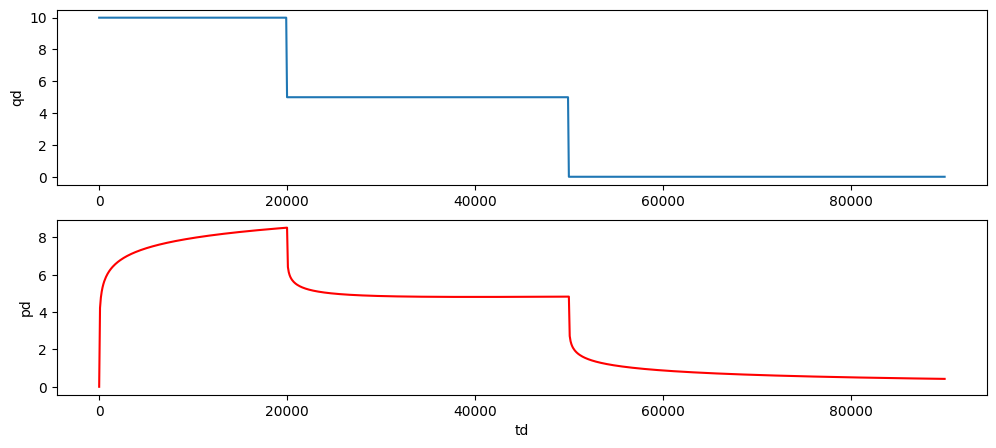

In [4]:
td_arr = np.linspace(1e-3, 9e4, 1000)


td_history = np.array([ 0., 2e4, 5e4 ], dtype=np.float64) 
qd_history = np.array([10., 5., 0.], dtype=np.float64)

plt.rcParams["figure.figsize"] = (12,5)
fig, (ax1, ax2) = plt.subplots(2,1)

ax1.plot(td_arr, q_superposition(td_arr, td_history, qd_history)) 
ax2.plot(td_arr, pd_superposition(td_arr, td_history, qd_history, rd=1), color='red') 
ax2.set_xlabel('td')
ax1.set_ylabel('qd')
ax2.set_ylabel('pd')
plt.show()

In [5]:
def p_superposition_atma(t_hr, t_hist_hr, q_hist_sm3day,
                         k_mD=10, h_m=10, b_m3m3=1.2, mu_cP=1, pi_atma=250, phi=0.2, 
                         ct_1atm=1e-05, rw_m=0.1):
    """
    расчет давления для запуска и последующей остановки скважины
    t_hr - время после запуска в часах
    t_hist_hr - массив времен изменения режимов работы скважин
    q_hist_sm3day - массив дебитов установленных после изменения режима работы
    k_mD=10 - проницаемость, мД, 
    h_m=10 - мощность пласта, м, 
    b_m3m3=1.2 - объемный коэффициент, м3/м3, 
    mu_cP=1 - вязкость нефти, сП, 
    pi_atma=250 - начальное давление, атм, 
    phi=0.2 - пористость, доли единиц, 
    ct_1atm=1e-05 - общая сжимаемость, 1/атм, 
    rw_m=0.1 - радиус скважины
    """
    q_ref=1.
    return wf.p_from_pd_atma(pd_superposition(wf.td_from_t(t_hr, k_mD=k_mD, phi=phi, mu_cP=mu_cP, 
                                                     ct_1atm=ct_1atm, rw_m=rw_m),
                                           wf.td_from_t(t_hist_hr, k_mD=k_mD, phi=phi, mu_cP=mu_cP, 
                                                     ct_1atm=ct_1atm, rw_m=rw_m),
                                           q_hist_sm3day / q_ref, 
                                           1), 
                          k_mD=10, h_m=10, q_sm3day=q_ref, b_m3m3=1.2, mu_cP=1, pi_atma=250)



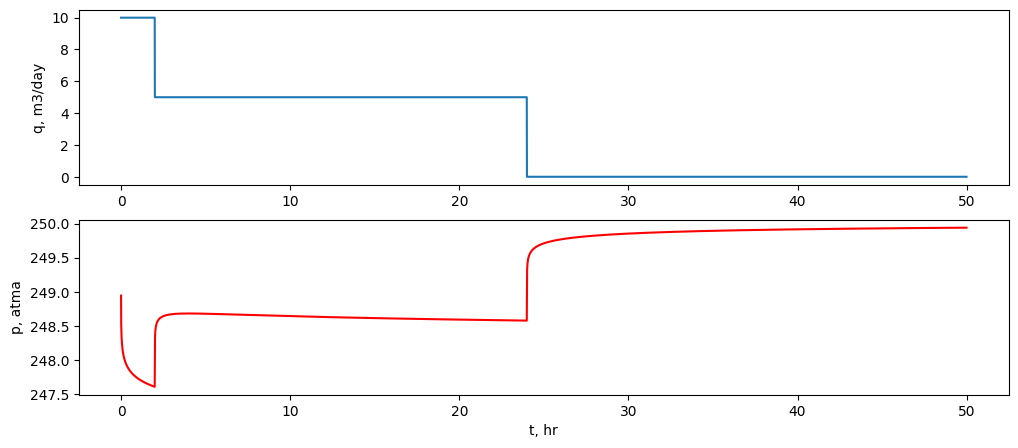

In [6]:
t_arr = np.arange(1e-3, 50, 1e-2)
plt.rcParams["figure.figsize"] = (12,5)

fig, (ax1, ax2) = plt.subplots(2,1)
ax1.plot(t_arr, q_superposition(t_arr, t_history, q_history)) 
ax2.plot(t_arr, p_superposition_atma(t_arr, t_history, q_history), color='red') 
ax2.set_xlabel('t, hr')
ax1.set_ylabel('q, m3/day')
ax2.set_ylabel('p, atma')
plt.show()

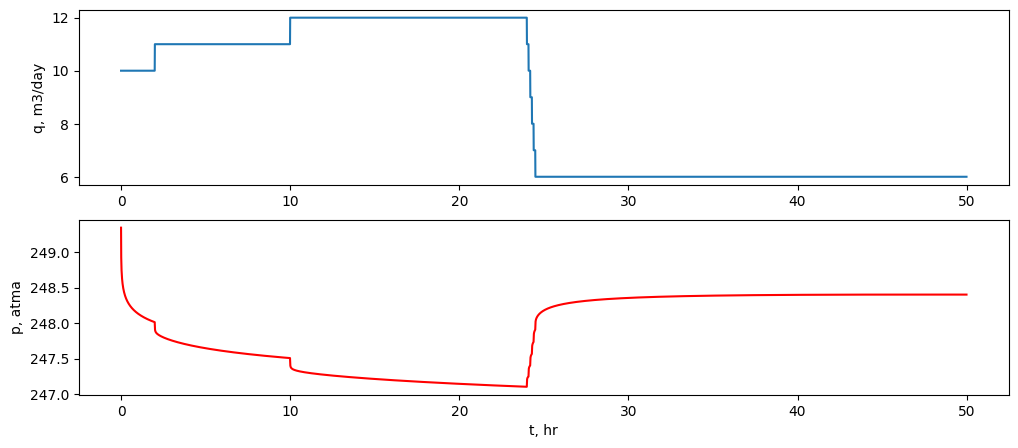

In [7]:

t_history = np.array([0, 2, 10, 24, 24.1,24.2,24.3,24.4,24.5 ])
q_history = np.array([10, 11, 12, 11, 10, 9, 8, 7, 6])

plt.rcParams["figure.figsize"] = (12,5)

fig, (ax1, ax2) = plt.subplots(2,1)
ax1.plot(t_arr, q_superposition(t_arr, t_history, q_history)) 
ax2.plot(t_arr, p_superposition_atma(t_arr, t_history, q_history, 1), color='red') 
ax2.set_xlabel('t, hr')
ax1.set_ylabel('q, m3/day')
ax2.set_ylabel('p, atma')
plt.show()

# 3. Случай для произвольной истории дебитов (линейное изменение дебита) <a class="anchor" id="353"></a>

In [10]:
import sympy as sp

In [11]:
rd, td, qd = sp.symbols('r_D t_D q_D')

In [12]:
# запишем решение в символьном виде для постоянного дебита
eq = -qd/2 * sp.Ei(-rd **2 / 4 / td)
display(eq)

-q_D*Ei(-r_D**2/(4*t_D))/2

для линейно меняющегося дебита $\theta_D t_D$ решение можно представить как интеграл

$$p_D = \int_0^{t_D}{- \frac{\theta_D}{2} Ei \left(- \dfrac{ r_D^2}{4t_d} \right) dt_D} \tag{8}$$

In [13]:
# проинтегрируем решение по времени
eq1 = sp.integrate(eq, td)
display(eq1)

-q_D*(r_D**2*Ei(-r_D**2/(4*t_D))/4 + t_D*Ei(-r_D**2/(4*t_D)) + t_D*exp(-r_D**2/(4*t_D)))/2



Для линейно меняющегося дебита во времени (как и для любой другой зависимости) надо решение проинтегрировать по времени (надо бы подробнее расписать - сделать это позже, например как у Щелкачева в основах нестационарной фильтрации на стр 321).

Для линейной зависимости дебита от времени 
$$
Q_D = \theta \cdot t_D \tag{9}
$$
можно получить выражение

$$
p_D(r_D,t_D, \theta) =-\frac{\theta t_D }{2} \left[ \left( 1+ \frac{r_D^2}{4 t_D} \right) Ei \left(- \dfrac{r_D^2}{4t_D} \right) + e^{-\dfrac{r_D^2}{4t_D}} \right] \tag{10}
$$

где $\theta$ - скорость изменения дебита.

Для таблично заданных дебитов и времен можно оценить 

$$
\theta_{(i)} = \dfrac{Q_{D(i)}-Q_{D(i-1)}}{t_{D(i)} - t_{D(i-1)} } \tag{11}
$$

Cравните формулу (11) с формулой (9.68) в книге Щелкачева "Основы неустановившейся фильтрации"

Тогда, используя принцип суперпозиции, можем выписать выражение для изменения давления на скважине и вокруг нее для произвольного момента времени

$$
P_{mr.D}(t_D, r_D) = \sum_i  p_D\left(t_D-t_{D(i)}, r_D, \theta_{(i+1)} - \theta_{(i)}\right)\cdot \mathcal{H}(t_D-t_{D(i)}) \tag{12}
$$

где

* $i$ - индекс значения дебита в таблице изменения дебитов
* $\theta_{(i)}$ - изменение безразмерного дебита относительно безразмерного времени (14.4) 
* $t_{D(i)}$ - безразмерный момент времени - включения дебита с номером $i$
* $t_{D}$ - безразмерный момент времени для которого проводится расчет
* $\mathcal{H}$ - ступенчатая [функция Хевисайда](https://ru.wikipedia.org/wiki/%D0%A4%D1%83%D0%BD%D0%BA%D1%86%D0%B8%D1%8F_%D0%A5%D0%B5%D0%B2%D0%B8%D1%81%D0%B0%D0%B9%D0%B4%D0%B0#:~:text=%D0%A4%D1%83%D0%BD%D0%BA%D1%86%D0%B8%D1%8F%20%D0%A5%D0%B5%D0%B2%D0%B8%D1%81%D0%B0%D0%B9%D0%B4%D0%B0%20%D1%88%D0%B8%D1%80%D0%BE%D0%BA%D0%BE%20%D0%B8%D1%81%D0%BF%D0%BE%D0%BB%D1%8C%D0%B7%D1%83%D0%B5%D1%82%D1%81%D1%8F%20%D0%B2,%D0%B4%D0%BB%D1%8F%20%D0%B7%D0%B0%D0%BF%D0%B8%D1%81%D0%B8%20%D1%8D%D0%BC%D0%BF%D0%B8%D1%80%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%BE%D0%B9%20%D1%84%D1%83%D0%BD%D0%BA%D1%86%D0%B8%D0%B8%20%D1%80%D0%B0%D1%81%D0%BF%D1%80%D0%B5%D0%B4%D0%B5%D0%BB%D0%B5%D0%BD%D0%B8%D1%8F.)
* $p_D\left(t\right)$ - зависимость безразмерного давление от времени - решение задачи запуска скважины с постоянным единичным дебитом
* $P_{mr.D} $ - безразмерное давление $P_{mr.D}(t_D, r_D)$ учитывающее историю изменения дебитов скважины

следует обратить внимание, при суперпозиции скорость изменения дебита вычисляется как $\theta{i+1)} - \theta{i)}$.  при реализации расчета необходимо предусмотреть, чтобы для первого и последнего шага расчет прошел корректно. Для этого можно, например, добавить к массивам дебитов и времени дополнительный значения в начале и в конце массивов соответствующие постоянным значениям дебита. 

Также надо учитывать, что в приведенном выражении массивы должны начинаться со значений $Q_D=0$



In [14]:
# Решение линейного стока уравнения фильтрации
def pd_lin_ei(td, rd=1, dqd_dtd=1):
    """
    Решение линейного стока уравнения фильтрации
    rd - безразмерное расстояние
    td - безразмерное время
    """
    # при расчете убедимся, что td=0 не повлияет на расчет, 
    # даже если td массив и нулевой только один элемент
    td = np.array(td, dtype = float)
    pd =  (1 + rd**2/4/td) * (-sc.expi(-rd**2 / 4 /td)) - np.exp(-rd**2 / 4 /td)
    return dqd_dtd * td * pd / 2

In [15]:
def pd_superposition_lin(td, td_hist, qd_hist):
    """
    расчет безразмерного давления для последовательности безразмерных дебитов
    td -  время расчета после запуска, безразмерное
    td_hist - массив времен изменения режимов работы скважин, безразмерное
    qd_hist - массив дебитов установленных после изменения режима работы, безразмерное
    """
    # принудительно добавим нули во входные массивы, чтобы учесть запуск скважины
    qdh = np.hstack([qd_hist])
    tdh = np.hstack([td_hist])
    # построим дебиты виртуальных скважин - разности реальных дебитов при переключении
    delta_qd = np.hstack([np.diff(qdh),0])
    delta_td = np.hstack([np.diff(tdh),1])
    
    dq_dt = delta_qd / delta_td
    dq_dt = np.diff(np.hstack([0, delta_qd / delta_td]))
    
    # референсный безразмерный дебит это 1
    
    # векторная магия - время может быть вектором и переключения дебитов тоже вектор
    # надо организовать сумму по временам, каждая из котороых сумма по переключениям
    # делаем при помощи расчета meshgrid и поиска накопленных сумм
    qd_v, td_v =np.meshgrid(delta_qd, td)
    
    dpd = np.cumsum(pd_lin_ei((td_v - tdh), dqd_dtd=dq_dt) * np.heaviside((td_v - tdh), 1),1 )

    return dpd[:,-1]

def p_superposition_lin_atma(t_hr, t_hist_hr, q_hist_sm3day,
                         k_mD=10, h_m=10, b_m3m3=1.2, mu_cP=1, pi_atma=250, phi=0.2, 
                         ct_1atm=1e-05, rw_m=0.1):
    """
    расчет давления для запуска и последующей остановки скважины
    t_hr - время после запуска в часах
    t_hist_hr - массив времен изменения режимов работы скважин
    q_hist_sm3day - массив дебитов установленных после изменения режима работы
    k_mD=10 - проницаемость, мД, 
    h_m=10 - мощность пласта, м, 
    b_m3m3=1.2 - объемный коэффициент, м3/м3, 
    mu_cP=1 - вязкость нефти, сП, 
    pi_atma=250 - начальное давление, атм, 
    phi=0.2 - пористость, доли единиц, 
    ct_1atm=1e-05 - общая сжимаемость, 1/атм, 
    rw_m=0.1 - радиус скважины
    """
    q_ref=1.
    return p_from_pd_atma(pd_superposition_lin(td_from_t(t_hr, k_mD=k_mD, phi=phi, mu_cP=mu_cP, 
                                                     ct_1atm=ct_1atm, rw_m=rw_m),
                                               td_from_t(t_hist_hr, k_mD=k_mD, phi=phi, mu_cP=mu_cP, 
                                                     ct_1atm=ct_1atm, rw_m=rw_m),
                                               q_hist_sm3day / q_ref), 
                          k_mD=10, h_m=10, q_sm3day=q_ref, b_m3m3=1.2, mu_cP=1, pi_atma=250)


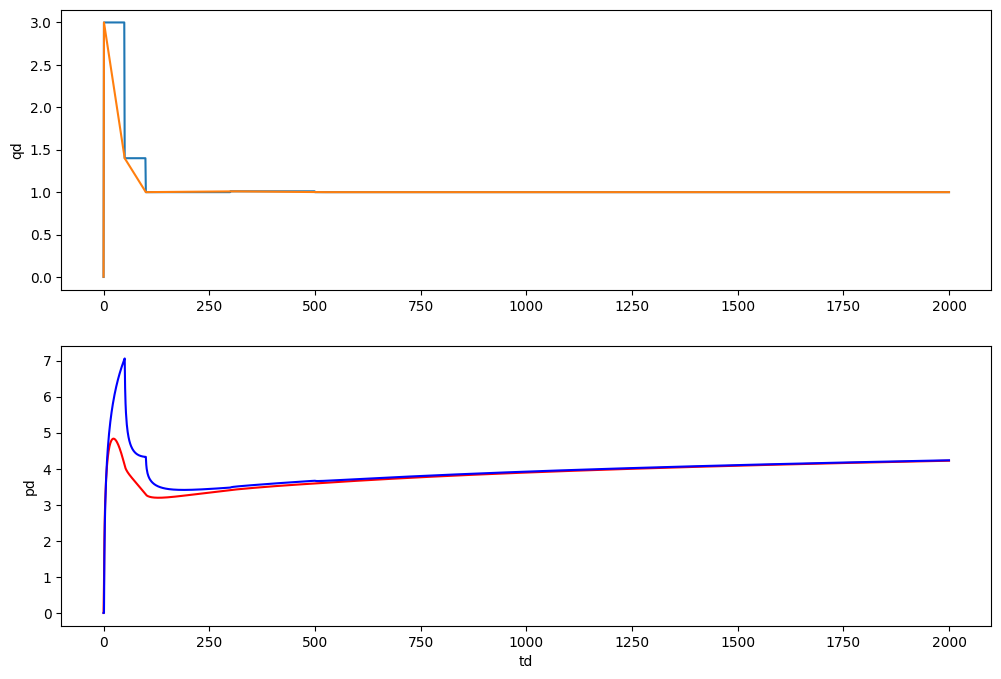

In [16]:
td_arr = np.linspace(1e-3, 2000, 2000)


td_history = np.array([0., 1, 50, 100, 300, 500 ], dtype=np.float64) 
qd_history = np.array([0., 3, 1.4, 1.0, 1.01, 1], dtype=np.float64)

plt.rcParams["figure.figsize"] = (12,8)
fig, (ax1, ax2) = plt.subplots(2,1)

ax1.plot(td_arr, q_superposition(td_arr, td_history, qd_history)) 
ax1.plot(td_arr, np.interp(td_arr, td_history, qd_history)) 
ax2.plot(td_arr, pd_superposition_lin(td_arr, td_history, qd_history), color='red') 
ax2.plot(td_arr, pd_superposition(td_arr, td_history, qd_history, rd=1), color='blue') 
ax2.set_xlabel('td')
ax1.set_ylabel('qd')
ax2.set_ylabel('pd')
plt.show()

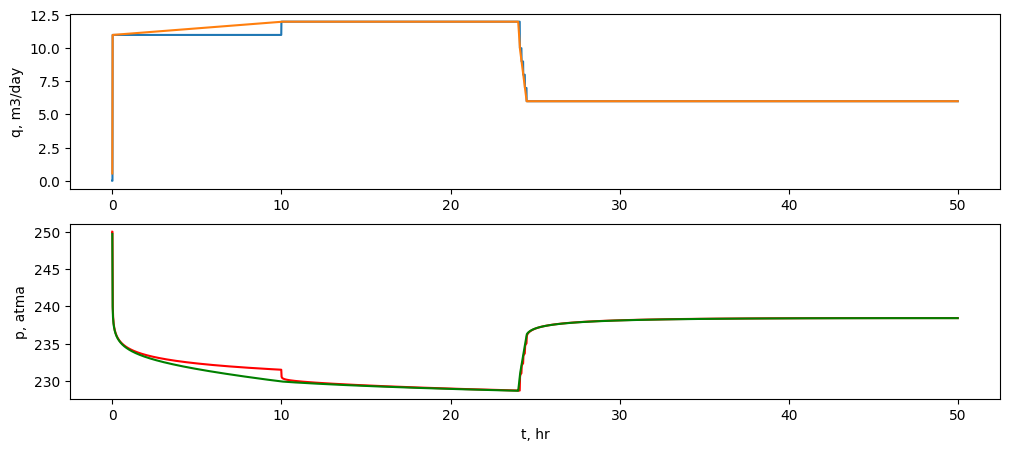

In [17]:
t_history = np.array([0, .02, 10, 24, 24.1,24.2,24.3,24.4,24.5 ])
q_history = np.array([0, 11, 12, 12, 10, 9, 8, 7, 6])

plt.rcParams["figure.figsize"] = (12,5)

fig, (ax1, ax2) = plt.subplots(2,1)
ax1.plot(t_arr, q_superposition(t_arr, t_history, q_history)) 
ax1.plot(t_arr, np.interp(t_arr, t_history, q_history)) 
ax2.plot(t_arr, p_superposition_atma(t_arr, t_history, q_history), color='red') 
ax2.plot(t_arr, p_superposition_lin_atma(t_arr, t_history, q_history), color='green') 
ax2.set_xlabel('t, hr')
ax1.set_ylabel('q, m3/day')
ax2.set_ylabel('p, atma')
plt.show()

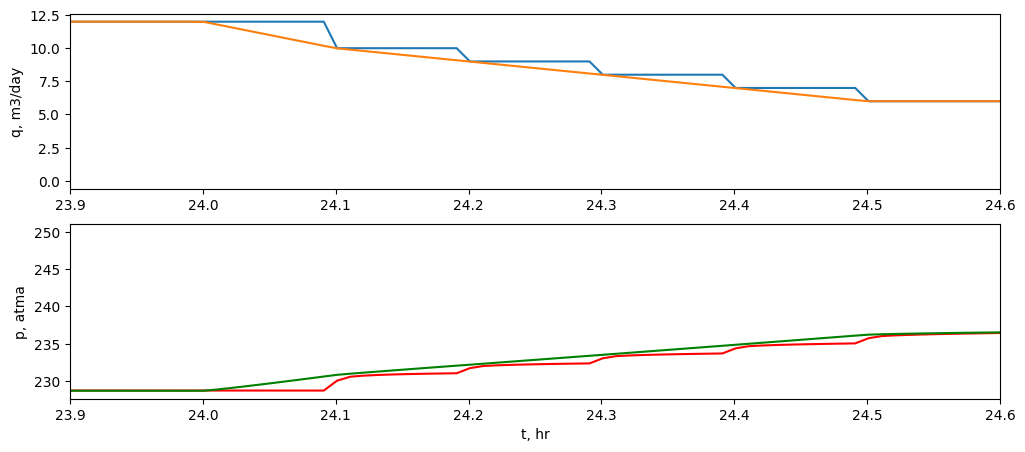

In [18]:
t_history = np.array([0, .02, 10, 24, 24.1,24.2,24.3,24.4,24.5 ])
q_history = np.array([0, 11, 12, 12, 10, 9, 8, 7, 6])

plt.rcParams["figure.figsize"] = (12,5)

fig, (ax1, ax2) = plt.subplots(2,1)
ax1.plot(t_arr, q_superposition(t_arr, t_history, q_history)) 
ax1.plot(t_arr, np.interp(t_arr, t_history, q_history)) 
ax2.plot(t_arr, p_superposition_atma(t_arr, t_history, q_history), color='red') 
ax2.plot(t_arr, p_superposition_lin_atma(t_arr, t_history, q_history), color='green') 
ax2.set_xlabel('t, hr')
ax1.set_ylabel('q, m3/day')
ax2.set_ylabel('p, atma')
ax1.set_xlim([23.9,24.6])
ax2.set_xlim([23.9,24.6])
plt.show()

# 4 Задания для самостоятельной работы <a class="anchor" id="354"></a>

Для совершенствования навыков работы с python выполните следующие задания:

1. Постройте решение для постоянного дебита. Аппрокимируйте получившуюся зависимость забойного давления от времени как кусочно линейную функцию и восстановите по ней дебиты используя решения для постоянного (или линейно меняющегося) дебита. Сравните получившееся решение с исходным.
2. Постройте решение для квадратично и кубично меняющегося дебита.
3. Построете решение для дебита изменяющегося как кубический сплайн.

# Список литературы

1. Kappa. Dynamic Data Analysis. The theory and practice of pressure transient, production analysis, well performance analysis, production logging and the use of permanent downhole gauge data. v4.12.02 Olivier Houze, Didier Viturat, Ole S. Fjare (et al)
2. Щелкачев В.Н. Основы и приложения теории неустановившейся фильтрации. М.: Нефть и газ, 1995 ч.1